In [1]:
import cv2
import numpy as np
import imutils
from imutils.video import FPS
from imutils.video import VideoStream

In [2]:
INPUT_FILE='../Vehicle Detection/videos/test.mp4'
OUTPUT_FILE='../Vehicle Detection/output.avi'
LABELS_FILE='../Vehicle Detection/yolo-coco/coco.names'
CONFIG_FILE='../Vehicle Detection/yolo-coco/yolov4.cfg'
WEIGHTS_FILE='../Vehicle Detection/yolo-coco/yolov4.weights'
CONFIDENCE_THRESHOLD=0.9
H=None
W=None

In [3]:
fps = FPS().start()

fourcc = cv2.VideoWriter_fourcc(*"MJPG")
writer = cv2.VideoWriter(OUTPUT_FILE, fourcc, 30,
	(800, 600), True)

LABELS = open(LABELS_FILE).read().strip().split("\n")

np.random.seed(4)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
	dtype="uint8")


net = cv2.dnn.readNetFromDarknet(CONFIG_FILE, WEIGHTS_FILE)

vs = cv2.VideoCapture(INPUT_FILE)


# determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]
cnt =0;
no = 0
while True:
	cnt+=1
	# print ("Frame number", cnt)
	try:
		(grabbed, image) = vs.read()
	except:
		break
	blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416),
		swapRB=True, crop=False)
	net.setInput(blob)
	if W is None or H is None:
		(H, W) = image.shape[:2]
	layerOutputs = net.forward(ln)


	# initialize our lists of detected bounding boxes, confidences, and
	# class IDs, respectively
	boxes = []
	confidences = []
	classIDs = []
	required_class = ["car", "motorbike", "bus", "truck"]
	min_width_height = {"car":[750, 550], "motorbike":[200, 300], "bus":[400, 400], "truck":[400, 400]}    
    
	# loop over each of the layer outputs
	for output in layerOutputs:
		# loop over each of the detections
		for detection in output:
			# extract the class ID and confidence (i.e., probability) of
			# the current object detection
			scores = detection[5:]
			classID = np.argmax(scores)
			confidence = scores[classID]

			# filter out weak predictions by ensuring the detected
			# probability is greater than the minimum probability
			if confidence > CONFIDENCE_THRESHOLD:
				# scale the bounding box coordinates back relative to the
				# size of the image, keeping in mind that YOLO actually
				# returns the center (x, y)-coordinates of the bounding
				# box followed by the boxes' width and height
				box = detection[0:4] * np.array([W, H, W, H])
				(centerX, centerY, width, height) = box.astype("int")

				# use the center (x, y)-coordinates to derive the top and
				# and left corner of the bounding box
				x = int(centerX - (width / 2))
				y = int(centerY - (height / 2))

				# update our list of bounding box coordinates, confidences,
				# and class IDs
				boxes.append([x, y, int(width), int(height)])
				confidences.append(float(confidence))
				classIDs.append(classID)

	# apply non-maxima suppression to suppress weak, overlapping bounding
	# boxes
	idxs = cv2.dnn.NMSBoxes(boxes, confidences, CONFIDENCE_THRESHOLD,
		CONFIDENCE_THRESHOLD)


	# ensure at least one detection exists
	if len(idxs) > 0:
		# loop over the indexes we are keeping
		for i in idxs.flatten():
			# extract the bounding box coordinates
			(x, y) = (boxes[i][0], boxes[i][1])
			(w, h) = (boxes[i][2], boxes[i][3])

			color = [int(c) for c in COLORS[classIDs[i]]]

			# print (str(x) + " " + str(w) + " " + str(y) + " " + str(h))

			if x < 0:
				x = 0
			if y < 0:
				y = 0
                
			crop = image[y:y+h, x:x+w]
			if(LABELS[classIDs[i]] in required_class):
				box_width = min_width_height[LABELS[classIDs[i]]][0]
				box_height = min_width_height[LABELS[classIDs[i]]][1]
				if(w > box_width and h > box_height):
					cv2.imwrite('output/{}{}.jpg'.format(LABELS[classIDs[i]], cnt), crop)
					no += 1

			cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
			text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
			cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
				0.5, color, 2)

	# show the output image
	cv2.imshow("output", cv2.resize(image,(800, 600)))
	writer.write(cv2.resize(image,(800, 600)))
	fps.update()
	key = cv2.waitKey(1) & 0xFF
	if key == ord("q"):
		break

fps.stop()

print("[INFO] elasped time: {:.2f}".format(fps.elapsed()))
print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))

# do a bit of cleanup
cv2.destroyAllWindows()

# release the file pointers
print("[INFO] cleaning up...")
writer.release()
vs.release()

[INFO] elasped time: 149.44
[INFO] approx. FPS: 0.86
[INFO] cleaning up...


In [4]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
import os
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from google.protobuf import text_format
%matplotlib inline

In [5]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [6]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [7]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [8]:
labels = [{'name':'licence', 'id':1}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

In [9]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [10]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-11')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

2022-06-14 07:24:17.371207: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-14 07:24:18.696089: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3368 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1


In [11]:
from pathlib import Path
# get the path/directory
folder_dir = 'output'
import pytesseract
import imutils
pytesseract.pytesseract.tesseract_cmd = 'tesseract'

detection_threshold = 0.5
 
image_paths = Path(folder_dir).glob('*.jpg')

In [12]:
def detect_plates(image_path):
    category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])
    IMAGE_PATH = image_path
    val = image_path.split('/')
    vehicle = ""
    frame = ""
    for i in val[1]:
        if i.isdigit():
            frame += i
    for i in val[1]:
        if i.isdigit():
            break;
        vehicle += i
    frame = int(frame)

    img = cv2.imread(IMAGE_PATH)
    image_np = np.array(img)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.5,
                agnostic_mode=False)
    image = image_np_with_detections
    scores = list(filter(lambda x : x > detection_threshold, detections['detection_scores']))
    boxes = detections['detection_boxes'][:len(scores)]
    classes = detections['detection_classes'][:len(scores)]
    width = image.shape[1]
    height = image.shape[0]
    plate_values = []
    plate_values.append(int(frame/24))
    plate_values.append(vehicle)
    
    for idx, box in enumerate(boxes):
        roi = box*[height, width, height, width]
        region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
        plate = pytesseract.image_to_string(region, lang='eng')
        plate_values.append(plate[:-1])
    
    # load the input image and convert it to grayscale
    gray = cv2.cvtColor(region, cv2.COLOR_BGR2GRAY)
    # threshold the image using Otsu's thresholding method
    thresh = cv2.threshold(gray, 0, 255,
        cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    # apply a distance transform which calculates the distance to the
    # closest zero pixel for each pixel in the input image
    dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
    # normalize the distance transform such that the distances lie in
    # the range [0, 1] and then convert the distance transform back to
    # an unsigned 8-bit integer in the range [0, 255]
    dist = cv2.normalize(dist, dist, 0, 1.0, cv2.NORM_MINMAX)
    dist = (dist * 255).astype("uint8")
    
    # threshold the distance transform using Otsu's method
    dist = cv2.threshold(dist, 0, 255,
        cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    plate = pytesseract.image_to_string(dist, lang='eng')
    plate_values.append(plate[:-1])   

    # plt.imshow(cv2.cvtColor(dist, cv2.COLOR_BGR2RGB))

    # apply an "opening" morphological operation to disconnect components
    # in the image
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    opening = cv2.morphologyEx(dist, cv2.MORPH_OPEN, kernel)
    
    # plt.imshow(cv2.cvtColor(opening, cv2.COLOR_BGR2RGB))
    plate = pytesseract.image_to_string(opening, lang='eng')
    plate_values.append(plate[:-1])   

    # find contours in the opening image, then initialize the list of
    # contours which belong to actual characters that we will be OCR'ing
    cnts = cv2.findContours(dist.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    chars = []
    # loop over the contours
    for c in cnts:
        # compute the bounding box of the contour
        (x, y, w, h) = cv2.boundingRect(c)
        # check if contour is at least 35px wide and 100px tall, and if
        # so, consider the contour a digit
        if w >= 10 and h >= 23 and w <= 50:
            chars.append(c)
    if chars:
        chars = np.vstack([chars[i] for i in range(0, len(chars))])
        hull = cv2.convexHull(chars)
        # allocate memory for the convex hull mask, draw the convex hull on
        # the image, and then enlarge it via a dilation
        mask = np.zeros(region.shape[:2], dtype="uint8")
        cv2.drawContours(mask, [hull], -1, 255, -1)
        mask = cv2.dilate(mask, None, iterations=2)
        
        # plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))

        # take the bitwise of the opening image and the mask to reveal *just*
        # the characters in the image
        final = cv2.bitwise_and(opening, opening, mask=mask)

        plate = pytesseract.image_to_string(final, lang='eng')
    plate_values.append(plate[:-1])
    return plate_values


In [13]:
list_to_convert = []
for image_path in image_paths:
    list_to_convert.append(detect_plates(str(image_path)))
list_to_convert

2022-06-14 07:24:59.559125: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8303


[[1, 'car', '29A-33185', '294 33185', '29A 33185', 'A  REEAR:E)'],
 [5, 'car', '30A-612.35', '', '30A-612\n\nN,\n\nI', '30A-61235'],
 [5, 'car', '30A-612.35', '30461235', 'AV', 'CILRR VRS'],
 [4, 'car', '30A-612.35', '30A-61235', '30A-61235', '30A-61235'],
 [1, 'car', '29A-33185', '29A-33185', 'TS', '294 33185'],
 [1, 'car', '29A-331.85', '29A-33185', '29A-33185', '29A-33185'],
 [5, 'car', '30A-612.35', '', '', 'SRR WARES'],
 [5, 'car', '30A-612.35', '30A-612.35', '30A-6', '30A-612.35'],
 [4, 'car', '30A-612.35', '', '30461235', '30461235'],
 [1, 'car', '', '29A-33185', '', '294 33185'],
 [5, 'car', '30A-612.35', '30A-612.35', '', '30A-612.35'],
 [4, 'car', '30A-612.35]', '30A-61235', '30A-61235)', '30A-61235'],
 [4, 'car', '', '', '30A 61235', '30A 61235'],
 [5, 'car', '[30A-612.35', '30A-612.35', '(30A-612.35', '30A-612.35'],
 [4, 'car', '30A-612.35', '—\n\n30A-612.35', '30A-61235', '30A-61235'],
 [4, 'car', '[30A 61235', '', 'J0A 61235', 'J0A 61235'],
 [4, 'car', '[30A-612.35', '', 

In [14]:
import pandas as pd

In [15]:
df = pd.DataFrame(list_to_convert, columns=['Time', 'Class', 'Original', 'Threshold', 'Opened', 'Masked'])
df

,Time,Class,Original,Threshold,Opened,Masked
0,1,car,29A-33185,294 33185,29A 33185,A REEAR:E)
1,5,car,30A-612.35,,"30A-612\n\nN,\n\nI",30A-61235
2,5,car,30A-612.35,30461235,AV,CILRR VRS
3,4,car,30A-612.35,30A-61235,30A-61235,30A-61235
4,1,car,29A-33185,29A-33185,TS,294 33185
5,1,car,29A-331.85,29A-33185,29A-33185,29A-33185
6,5,car,30A-612.35,,,SRR WARES
7,5,car,30A-612.35,30A-612.35,30A-6,30A-612.35
8,4,car,30A-612.35,,30461235,30461235
9,1,car,,29A-33185,,294 33185


In [16]:
df.to_csv("result.csv")

In [46]:
def most_frequent(List):
    return max(set(List), key = List.count)

In [47]:
for val in list_to_convert:
    print(most_frequent(val))

1
29A-33185%
30461235
30A-612.35


In [23]:
image = image_np_with_detections
scores = list(filter(lambda x : x > detection_threshold, detections['detection_scores']))
boxes = detections['detection_boxes'][:len(scores)]
classes = detections['detection_classes'][:len(scores)]
width = image.shape[1]
height = image.shape[0]

Number plate 0: 30A-612.35



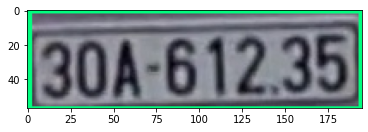

In [24]:
for idx, box in enumerate(boxes):
    roi = box*[height, width, height, width]
    region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
    plate = pytesseract.image_to_string(region, lang='eng')
    print("Number plate 0:", plate)    
    plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))

Dist
Number plate 1: 
Opening
Number plate 2: 30A 61235

Final
Number plate 3: 30A 61235



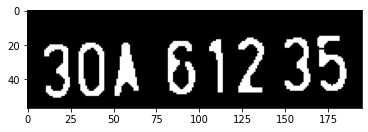

In [25]:
# load the input image and convert it to grayscale
gray = cv2.cvtColor(region, cv2.COLOR_BGR2GRAY)
# threshold the image using Otsu's thresholding method
thresh = cv2.threshold(gray, 0, 255,
	cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

# apply a distance transform which calculates the distance to the
# closest zero pixel for each pixel in the input image
dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
# normalize the distance transform such that the distances lie in
# the range [0, 1] and then convert the distance transform back to
# an unsigned 8-bit integer in the range [0, 255]
dist = cv2.normalize(dist, dist, 0, 1.0, cv2.NORM_MINMAX)
dist = (dist * 255).astype("uint8")
print("Dist")
# threshold the distance transform using Otsu's method
dist = cv2.threshold(dist, 0, 255,
	cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
plate = pytesseract.image_to_string(dist, lang='eng')
print("Number plate 1:", plate)    

# plt.imshow(cv2.cvtColor(dist, cv2.COLOR_BGR2RGB))

# apply an "opening" morphological operation to disconnect components
# in the image
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
opening = cv2.morphologyEx(dist, cv2.MORPH_OPEN, kernel)
print("Opening")
# plt.imshow(cv2.cvtColor(opening, cv2.COLOR_BGR2RGB))
plate = pytesseract.image_to_string(opening, lang='eng')
print("Number plate 2:", plate)    

# find contours in the opening image, then initialize the list of
# contours which belong to actual characters that we will be OCR'ing
cnts = cv2.findContours(dist.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
chars = []
# loop over the contours
for c in cnts:
	# compute the bounding box of the contour
	(x, y, w, h) = cv2.boundingRect(c)
	# check if contour is at least 35px wide and 100px tall, and if
	# so, consider the contour a digit
	if w >= 10 and h >= 23 and w <= 50:
		chars.append(c)
if chars:
    chars = np.vstack([chars[i] for i in range(0, len(chars))])
    hull = cv2.convexHull(chars)
    # allocate memory for the convex hull mask, draw the convex hull on
    # the image, and then enlarge it via a dilation
    mask = np.zeros(region.shape[:2], dtype="uint8")
    cv2.drawContours(mask, [hull], -1, 255, -1)
    mask = cv2.dilate(mask, None, iterations=2)
    print("Final")
    # plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))

    # take the bitwise of the opening image and the mask to reveal *just*
    # the characters in the image
    final = cv2.bitwise_and(opening, opening, mask=mask)

    plt.imshow(cv2.cvtColor(final, cv2.COLOR_BGR2RGB))

    plate = pytesseract.image_to_string(final, lang='eng')
    print("Number plate 3:", plate)    